In [5]:
import pandas as pd
from itertools import combinations
from collections import defaultdict, Counter
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix

%matplotlib inline

In [6]:
df_lang = pd.read_csv("../datasets/languages/languoid.csv")
id2iso = dict(zip(df_lang["id"], df_lang["iso639P3code"]))


# Lang2lang matrix

In [84]:
df_clics  = pd.read_csv("../datasets/lang2lang/clics3_pmi.csv")

In [85]:
df_clics["Target"]=df_clics["Target"].map(id2iso)
df_clics["Source"]=df_clics["Source"].map(id2iso)

In [75]:
# df_clics.to_csv("../datasets/data_for_graph/clics3.csv",index=False)

In [86]:
df_clics["pmi_norm"].min(), df_clics["pmi_norm"].max()

(0.0, 1.0)

In [88]:
df_clics = df_clics.dropna(subset=["Target", "Source"])

In [91]:
df_clics[["Target", "Source", "pmi_norm"]]

,Target,Source,pmi_norm
92,goh,mri,0.403282
93,goh,yad,0.418468
94,goh,pnb,0.417288
95,goh,tam,0.395338
96,goh,kya,0.382396
...,...,...,...
457572,eng,nio,0.307693
457573,nor,rus,0.395022
457574,bhw,lmf,0.557536
457579,nbc,kbx,0.671518


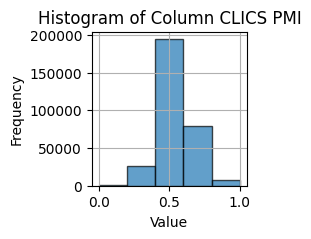

In [89]:
plt.figure(figsize=(2, 2))
plt.hist(df_clics['pmi_norm'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Histogram of Column CLICS PMI')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [93]:
pmi_matrix_expanded = df_clics.pivot(index='Target', columns='Source', values='pmi_norm')

# Ensure that the resulting DataFrame is symmetric
# Create a complete list of unique languages from the 'Target' and 'Source'
languages = sorted(set(df_clics['Target']).union(set(df_clics['Source'])))

# Reindex the DataFrame to ensure symmetry, filling missing values with NaN
pmi_matrix_symmetric = pmi_matrix_expanded.reindex(index=languages, columns=languages)

In [94]:
pmi_matrix_symmetric.to_csv("../dataset/

Source,aac,aax,abk,abq,abw,abz,aca,acn,adg,adn,...,zin,ziz,zka,zku,zmc,zmu,zng,zuh,zun,zzj
Target,,,,,,,,,,,,,,,,,,,,,
aac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abk,NaN,0.493223,NaN,NaN,NaN,0.332257,NaN,0.478912,NaN,NaN,...,0.537977,NaN,0.570967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zmu,NaN,NaN,0.570967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57748,0.551844
zng,0.617550,NaN,0.319467,NaN,NaN,0.426664,NaN,0.483931,NaN,0.463192,...,0.486599,NaN,0.575987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zuh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
pmi_matrix_symmetric.at["deu", "nld"], pmi_matrix_symmetric.at["nld", "deu"]

(0.5190226393683233, 0.5636561997487483)

# CLICS from Babelnet

In [7]:
clics= pd.read_csv("../datasets/raw/colexifications/colex_clics3.csv")

In [8]:
len(clics)

76346

In [9]:
clics =clics[["ISO639P3code", "Colex_ID"]]

In [10]:
clics["Presence"]=1

In [11]:
clics = clics.dropna(subset=["ISO639P3code"])

In [12]:
clics

,ISO639P3code,Colex_ID,Presence
8,goh,0,1
9,mri,0,1
10,yad,0,1
11,pnb,0,1
12,tam,0,1
...,...,...,...
76341,aol,4227,1
76342,abz,4227,1
76343,kgv,4227,1
76344,kyo,4227,1


In [13]:
binary_matrix = clics.pivot_table(
    index='ISO639P3code', 
    columns='Colex_ID', 
    values="Presence",
    aggfunc='max', 
    fill_value=0
)

In [14]:
binary_matrix

Colex_ID,0,1,2,3,4,5,6,7,8,9,...,4218,4219,4220,4221,4222,4223,4224,4225,4226,4227
ISO639P3code,,,,,,,,,,,,,,,,,,,,,
aac,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aau,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aax,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zmu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zng,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zuh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def crop_wals(gb_df, perc):
    """Remove languages from dataframe that do not have at least <perc>% feature coverage"""
    rows_list=[]
    tot_feats = len([x for x in gb_df.columns])
    for i, row in gb_df.iterrows():
        no_data = row.to_list().count(0)
        # print(i, no_data)
        if (tot_feats - no_data) >=3:
            rows_list.append(row)
            # try:
            #     gb_df = gb_df.drop(i)
            # except Exception as msg:
            #     print(msg)

    return pd.concat(rows_list, axis=1)

In [17]:
clics_matrx = crop_wals(binary_matrix, perc=0.01)

In [18]:
len(clics_matrx), len(binary_matrix)

(4228, 1609)

In [19]:
clics_matrx= clics_matrx.T

In [20]:
clics_matrx.loc["deu"].to_numpy()[clics_matrx.loc["deu"].to_numpy()!=0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
clics_matrx.loc["cmn"].to_numpy()[clics_matrx.loc["cmn"].to_numpy()!=0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
from scipy.spatial.distance import pdist, squareform


In [30]:
jaccard_distance_matrix.shape

(1347, 1347)

In [23]:
jaccard_distances = pdist(clics_matrx, metric='jaccard')
jaccard_distance_matrix = squareform(jaccard_distances)

In [24]:
jaccard_df = pd.DataFrame(
    jaccard_distance_matrix, 
    index=clics_matrx.index, 
    columns=clics_matrx.index
)

In [25]:
jaccard_df.at["deu", "eng"], jaccard_df.at["deu", "nld"]

(0.8685714285714285, 0.7155172413793104)

In [26]:
jaccard_df.at["deu", "dan"], jaccard_df.at["dan", "nor"], jaccard_df.at["cmn", "jpn"],  jaccard_df.at["cmn", "kor"]

(0.7766497461928934, 0.753731343283582, 0.8927335640138409, 0.9386503067484663)

In [27]:
jaccard_df

,aac,aax,aaz,abk,abq,abw,abz,aca,acn,adg,...,zin,ziz,zka,zku,zmc,zmu,zng,zuh,zun,zzj
aac,0.000000,1.000000,0.968750,1.000000,1.000000,1.0,0.985507,1.0,1.000000,1.000000,...,1.000000,1.0,1.000000,1.0,0.909091,1.000000,0.990991,1.000000,1.000000,0.992958
aax,1.000000,0.000000,1.000000,0.991597,1.000000,1.0,0.987342,1.0,1.000000,1.000000,...,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
aaz,0.968750,1.000000,0.000000,1.000000,0.971429,1.0,0.956989,1.0,1.000000,1.000000,...,1.000000,1.0,0.970588,1.0,0.973684,1.000000,0.954887,0.970588,0.984848,0.982036
abk,1.000000,0.991597,1.000000,0.000000,1.000000,1.0,0.994220,1.0,0.985294,1.000000,...,0.983333,1.0,0.990991,1.0,1.000000,0.990991,0.995349,1.000000,0.995238,0.983539
abq,1.000000,1.000000,0.971429,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,...,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zmu,1.000000,1.000000,1.000000,0.990991,1.000000,1.0,1.000000,1.0,1.000000,0.750000,...,1.000000,1.0,1.000000,1.0,0.833333,0.000000,1.000000,1.000000,0.990741,0.993056
zng,0.990991,1.000000,0.954887,0.995349,1.000000,1.0,0.982659,1.0,0.985507,0.991150,...,0.991870,1.0,0.991150,1.0,0.982759,1.000000,0.000000,1.000000,0.960976,0.888393
zuh,1.000000,1.000000,0.970588,1.000000,1.000000,1.0,0.985915,1.0,1.000000,1.000000,...,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
zun,1.000000,1.000000,0.984848,0.995238,1.000000,1.0,0.994118,1.0,0.992537,1.000000,...,1.000000,1.0,1.000000,1.0,1.000000,0.990741,0.960976,1.000000,0.000000,0.943723


In [66]:
jaccard_df.to_csv("../datasets/lang2lang/clics3_jaccard.csv")

In [4]:
colex_df= pd.read_csv("../datasets/colexifications/colex_clics3.csv")

In [5]:
colex_df.head(2)

,Form_ID_x,Form_ID_y,Concepticon_ID_x,Concepticon_ID_y,Colex_ID,Language_ID,Parameter_ID,Value,Form,Language_Name,...,ISO639P3code,Macroarea,Family,Wals_ID,Wals_Name,Latitude,Longitude,Glottocode_wals,Subfamily,Genus
0,Chaozhou-61_soilearth-1,Chaozhou-60_mudearth-1,1228,640,0,Chaozhou,61_soilearth,tʰou⁵⁵,tʰou⁵⁵,Chaozhou,...,NaN,Eurasia,Sino-Tibetan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chengdu-61_soilearth-1,Chengdu-60_mudearth-1,1228,640,0,Chengdu,61_soilearth,ȵi³¹pa⁴⁴,ȵi³¹pa⁴⁴,Chengdu,...,NaN,NaN,Sino-Tibetan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
colex_dict, num_of_colexification_ignoring_forms =  co_occurrence_table(colex_df, "Glottocode_clics")

len of colexification df: 76346
len of df after droping duplicates for Glottocode_clics: 66827


In [7]:
glotto2colex_nr = colex_df.groupby(["Glottocode_clics"])["Colex_ID"].count().to_dict()

In [8]:
colexnr_array = list(glotto2colex_nr.values())

## Finding the threshold for including languages which contain colexifications

In [9]:
np.max(colexnr_array)

np.int64(1335)

In [18]:
def get_quantile_box(arr):
    # quantiles=np.quantile(arr, np.linspace(0,1,1335))
    # plt.plot(np.linspace(0,1,1335), quantiles)
    plt.boxplot(arr)
    plt.xlabel('Quantile')
    plt.ylabel('Value')
    plt.title('Quantile Plot')
    plt.show()

In [23]:
q25 = np.quantile(colexnr_array, 0.25)

print(f"The 25% quantile is: {q25:.4f}")

The 25% quantile is: 3.0000


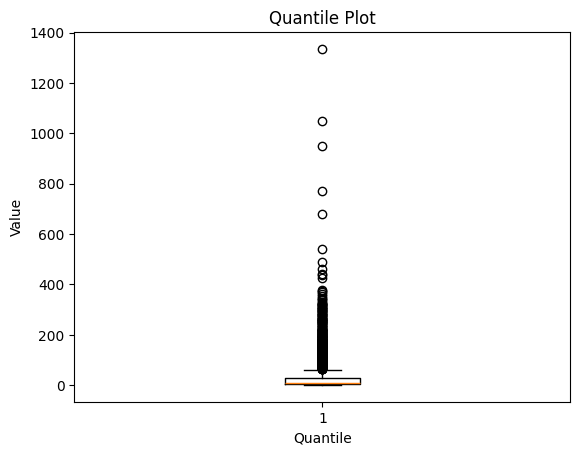

In [19]:
get_quantile_box(colexnr_array)

In [20]:
def get_quantile_violin(arr):
    # quantiles=np.quantile(arr, np.linspace(0,1,1335))
    # plt.plot(np.linspace(0,1,1335), quantiles)
    plt.violinplot(arr)
    plt.xlabel('Quantile')
    plt.ylabel('Value')
    plt.title('Quantile Plot')
    plt.show()

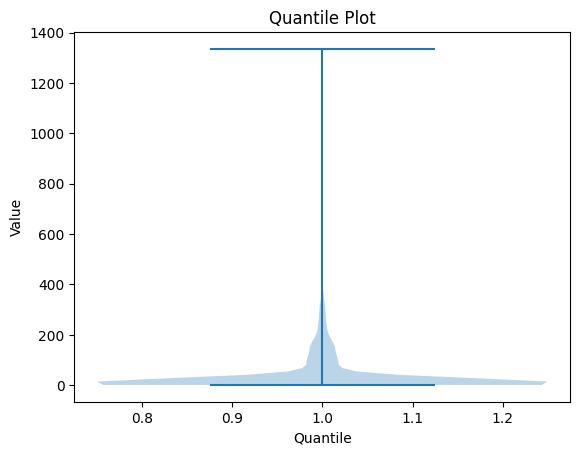

In [22]:
get_quantile_violin(colexnr_array)

In [24]:
lang2colex_nr = {lang: colex_nr for lang,colex_nr in glotto2colex_nr.items() if colex_nr>=3}

In [27]:
len(lang2colex_nr), len(glotto2colex_nr)

(1641, 1989)

In [31]:
langs_list = list(lang2colex_nr.keys())

In [38]:
df = pd.DataFrame(list(colex_dict.items()), columns=["Key", "Value"])

In [40]:
df[["Target", "Source"]] = pd.DataFrame(df["Key"].tolist(), index=df.index)

In [44]:
df = df.rename(columns={"Value":"Weight"})

In [45]:
df = df[["Target", "Source", "Weight"]]

In [49]:
df["Colex_target"] = df["Target"].apply(lambda x: lang2colex_nr.get(x, None))
df["Colex_source"] = df["Source"].apply(lambda x: lang2colex_nr.get(x, None))

In [51]:
df = df.dropna()

In [58]:
df.head(2) 

,Target,Source,Weight,Colex_target,Colex_source
0,chao1238,chen1267,3,8.0,9.0
1,chao1238,fuzh1239,4,8.0,7.0


In [54]:
from nltk.metrics import *
import pandas as pd

bm = BigramAssocMeasures

In [55]:
total_colex_nr = sum(list(lang2colex_nr.values()))
total_colex_nr

75842

In [59]:
def calculate_pmi(x,y,z):
    pmi = bm.pmi(x,(y,z), total_colex_nr)
    return pmi

In [60]:
df["pmi"] = df.apply(lambda row: calculate_pmi(row["Weight"], row["Colex_target"], row["Colex_source"]), axis=1)

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_94032/4107798813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pmi"] = df.apply(lambda row: calculate_pmi(row["Weight"], row["Colex_target"], row["Colex_source"]), axis=1)


In [63]:
df.to_csv("../datasets/lang2lang/clics3.csv", index=False)

In [64]:
def get_boxplot(arr):
    # quantiles=np.quantile(arr, np.linspace(0,1,1335))
    # plt.plot(np.linspace(0,1,1335), quantiles)
    plt.boxplot(arr)
    plt.xlabel('PMI')
    plt.ylabel('Value')
    plt.title('Plot')
    plt.show()

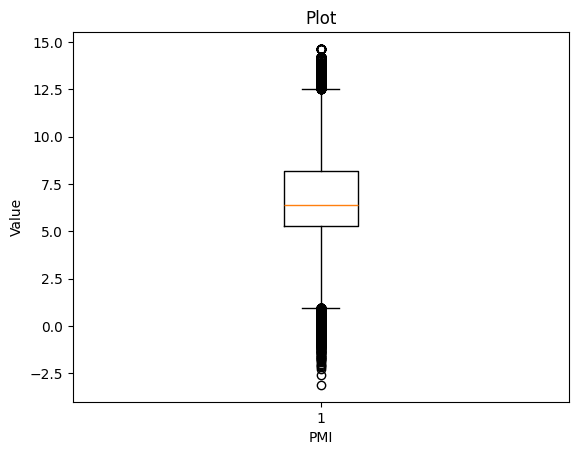

In [65]:
get_boxplot(df["pmi"].tolist())

In [2]:
df = pd.read_csv("../datasets/lang2lang/clics3.csv")

In [10]:
x_min=df["pmi"].min()
x_max=df["pmi"].max()

In [11]:
x_min, x_max

(np.float64(-3.10560529248788), np.float64(14.625746888318115))

In [12]:
def normalize(x):
    return (x - x_min) / (x_max - x_min)

In [72]:
df.head(2)

,Target,Source,Weight,Colex_target,Colex_source,pmi,pmi_norm
0,chao1238,chen1267,3,8.0,9.0,11.625747,0.830808
1,chao1238,fuzh1239,4,8.0,7.0,12.403354,0.874663


In [13]:
df["pmi_norm"] = df["pmi"].apply(normalize)

In [15]:
df.to_csv("../datasets/lang2lang/clics3.csv", index=False)